In [1]:
# IRL AutoRegressive 2:
# In this algorithm, SQP is embedded within the IRL block to ensure a higher optimality of the resulting trajectory
# based on the distance of the new trajectory with the optimal trajectory in the feature space

In [2]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [3]:
nx = 4
nu = 2
T = 20
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1.5
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(4, 3.5, 2, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 6, 1, obs_act, 'Obs3')
obs4 = Obstacle(4, 4, 1, obs_act, 'Obs4')
obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2]#, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
# cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [4]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 1000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [5]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
xs_optimal = XS_Set_optimal[0]
us_optimal = US_Set_optimal[0]
# xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 24 Rejected
30 Trajectories Collected
Trajectory 33 Rejected
Trajectory 34 Rejected
Trajectory 35 Rejected
40 Trajectories Collected
Trajectory 43 Rejected
Trajectory 44 Rejected
Trajectory 45 Rejected
50 Trajectories Collected
Trajectory 54 Rejected
Trajectory 55 Rejected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected
100 Trajectories Collected


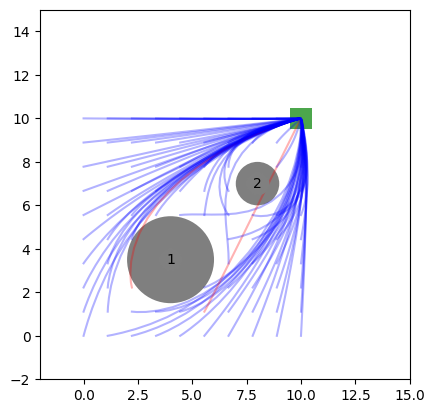

2


In [6]:
print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

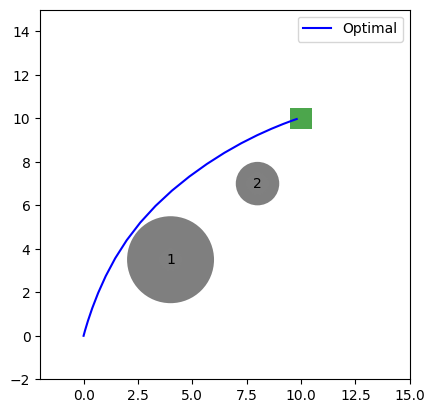

In [7]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [8]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)
_, _, sqp_loop = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [9]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [10]:
# IRL Algorithm
def fcn_autoreg_sqp(x, IRL_args, solver_args):
    # Parsing the arguments
    xs_optimal = IRL_args['xs_opt'].copy(); us_optimal = IRL_args['us_opt'].copy()
    xs_non_optimal_set = IRL_args['xs_non_opt_set'].copy(); us_non_optimal_set = IRL_args['us_non_opt_set'].copy()
    dt = solver_args['dt']
    cost_set = IRL_args['cost_set']
    nr = cost_set.nr
    T = solver_args['T']
    
    # Cumulative Features and costs for the desired and the initial bad trajectories
    opt_traj_feat = cost_set.cum_feat(xs_optimal, us_optimal, dt)
    bad_traj_feat = cost_set.cum_feat(np.zeros_like(xs_optimal), np.zeros_like(us_optimal), dt)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    bad_traj_cost = cost_set.traj_cost(np.zeros_like(xs_optimal), np.zeros_like(us_optimal), x[:nr], x[nr:], dt)

    # Resetting the weights of the solver and solving with weights 'x'
    solver = reset_weights(solver_args['solver'], x[:nr], x[nr:])
    solver.with_callbacks = solver_args['callback']
    solver.termination_tolerance = solver_args['solver_tol']
    xs_init = [solver_args['prev_x'][i] for i in range(T+1)]
    us_init = [solver_args['prev_u'][i] for i in range(T)]
    solver.solve(xs_init, us_init, solver_args['max_iter'])
    xs_non_optimal_set.append(np.vstack(solver.xs.tolist().copy()))
    us_non_optimal_set.append(np.vstack(solver.us.tolist().copy()))
    new_traj_feat = cost_set.cum_feat(solver.xs.copy(), solver.us.copy(), dt)
    
    
    output = 0; den = 0
    # Negative log term
    num = np.max([np.nextafter(0,1),np.exp(-opt_traj_cost)])
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        if IRL_args['use_factor']:
            non_opt_traj_feat = cost_set.cum_feat(Xs, Us, dt)
            alpha = np.exp(np.linalg.norm(opt_traj_feat - non_opt_traj_feat)/(np.linalg.norm(opt_traj_feat - bad_traj_feat)))
            den += np.max([np.nextafter(0,1),alpha*np.exp(-non_opt_traj_cost)])
        else:
            den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)

    # Weight Regularization Term
    output += IRL_args['Lambda']*np.linalg.norm(x)**2

    # Feature Regularization Term
    output += IRL_args['Beta']*(np.linalg.norm(opt_traj_feat - new_traj_feat)/np.linalg.norm(opt_traj_feat - bad_traj_feat))**2
    
    return output

In [11]:
xs_non_optimal_set = []; xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set = []; us_non_optimal_set.append(np.vstack(us_non_optimal).copy())

solver_args = {
    'solver': sqp_loop,
    'max_iter': 5,
    'T': T,
    'dt': timeStep,
    'callback': False,
    'solver_tol': 1e-4,
    'prev_x': xs_non_optimal,
    'prev_u': us_non_optimal
}

IRL_args = {
    'cost_set': cost_set,
    'xs_opt': xs_optimal,
    'us_opt': us_optimal,
    'xs_non_opt_set': xs_non_optimal_set,
    'us_non_opt_set': us_non_optimal_set,
    'Lambda': 0.01,
    'Beta': 1.0,
    'use_factor': True
}

# Optimizer Parameters
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxls': 5, 'maxiter': 4, 'iprint': -1,'ftol': 1e-3 ,'gtol' : 1e-3}
tol = 1e-4

# w_loop = w_bad
w_loop = np.random.uniform(0.0, 1.0, size=len(w_des))
# w_loop = np.ones_like(w_des)
w_prev = w_loop
w0 = w_loop
it = 0
max_set_size = 5
# it_max_IRL = max_set_size + 1
it_max_IRL = 10

xs = []
us = []
ws = []
Fcns= []
Cost_Diffs = []
W_Diffs = []
Traj_Diffs = []
Opt_Vals = []
opt_tol = 1e-4

xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_loop)

init_choices = ['bad','optimal','previous']
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,solver_args['dt'])
non_opt_feat = cost_set.cum_feat(np.zeros_like(xs_optimal), np.zeros_like(us_optimal), solver_args['dt'])
optimality = 1
while optimality > opt_tol and it < it_max_IRL:

    res = minimize(fcn_autoreg_sqp, 
                   w_loop, 
                   args=(IRL_args, solver_args), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    # print(res.x)
    w_loop = res.x.copy()
    if np.max(w_loop) != 0.0:
        w_loop /= np.max(w_loop)
    fcn_value = fcn_autoreg_sqp(w_loop,IRL_args, solver_args)
    # fcn_value = 0.0
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]

    sqp_non_opt = reset_weights(sqp_non_opt, w_loop[:nr], w_loop[nr:])
    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [xs[-1][i] for i in range(T+1)]
        us_init = [us[-1][i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]

    done = sqp_non_opt.solve(xs_init, us_init, solver_args['max_iter'])
    solver_args['prev_x'] = sqp_non_opt.xs.copy()
    solver_args['prev_u'] = sqp_non_opt.us.copy()
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())
    
    traj_feat = cost_set.cum_feat(sqp_non_opt.xs.tolist().copy(), sqp_non_opt.us.tolist().copy(), solver_args['dt'])
    optimality = ((np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)))**2
    Opt_Vals.append(optimality)
    
    if len(xs) <= max_set_size:
        IRL_args['xs_non_opt_set'] = xs
        IRL_args['us_non_opt_set'] = us
    else:
        IRL_args['xs_non_opt_set'] = xs[-max_set_size:]
        IRL_args['us_non_opt_set'] = us[-max_set_size:]
        
    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], solver_args['dt'])- cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], solver_args['dt']))**2             
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], solver_args['dt']))**2
    Cost_Diffs.append(opt_diff)
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)
    if it > 0:
        print('Fcn Value: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimality: {:.4f}'.format(
            fcn_value, w_diff, traj_diff, optimality
        ))
    
    w_prev = w_loop.copy()
    it += 1
    # if it == it_max_IRL-1:
    #     # options['maxiter'] = 200
    #     xs_non_optimal_set = xs
    #     us_non_optimal_set = us

print(res)
# w_irl = res.x/np.max(res.x)
w_irl = w_loop
# w_irl = ws[ws.index(min(ws))+1]

Fcn Value: 8.7503 || Weight Diff: 0.9229 || Traj Diff: 64.7225, || Optimality: 0.2228
Fcn Value: 1.4306 || Weight Diff: 0.1925 || Traj Diff: 0.9331, || Optimality: 0.0011
Fcn Value: 0.9978 || Weight Diff: 0.7446 || Traj Diff: 0.0008, || Optimality: 0.0058
Fcn Value: 1.3030 || Weight Diff: 0.0283 || Traj Diff: 0.0002, || Optimality: 0.0000
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.3017396436478754
        x: [ 0.000e+00  0.000e+00  5.099e-04  8.527e-01  2.997e-01
             1.013e+00  0.000e+00  3.316e-04  1.170e-02  1.341e-01]
      nit: 3
      jac: [-2.852e-01  2.940e-01 -3.997e+01 -4.995e-02 -4.261e-02
            -1.846e-02  3.571e-01  6.617e-06  2.340e-04 -4.537e-03]
     nfev: 77
     njev: 7
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>


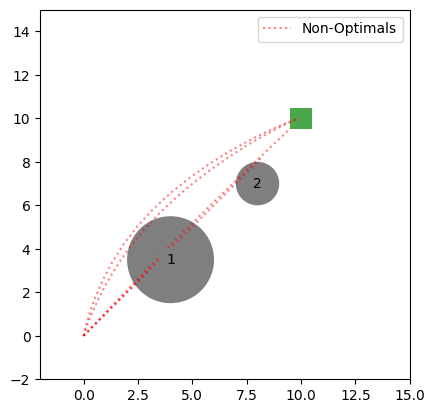

In [12]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [13]:
w_loop

array([0.00000000e+00, 0.00000000e+00, 5.03140474e-04, 8.41399819e-01,
       2.95762534e-01, 1.00000000e+00, 0.00000000e+00, 3.27163229e-04,
       1.15433032e-02, 1.32322686e-01])

In [14]:
n = Opt_Vals.index(min(Opt_Vals))
print(n, min(Opt_Vals))

4 3.285039543925144e-05


In [15]:
Opt_Vals

[0.9413580177833408,
 0.22283357499885062,
 0.0011384320499445222,
 0.005812206606894383,
 3.285039543925144e-05]

In [16]:
w_irl = ws[-1]
# w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  1.0

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0005031404736153277
Terminal ||  Desired:  0.0005 IRL:  0.0003271632294353605

Obs1 :
Running ||  Desired:  1.0 IRL:  0.841399818556142
Terminal ||  Desired:  0.5 IRL:  0.011543303236302723

Obs2 :
Running ||  Desired:  1.0 IRL:  0.29576253374418476
Terminal ||  Desired:  0.5 IRL:  0.13232268568946579



In [17]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 24 Rejected
30 Trajectories Collected
Trajectory 33 Rejected
Trajectory 34 Rejected
Trajectory 35 Rejected
40 Trajectories Collected
Trajectory 43 Rejected
Trajectory 44 Rejected
Trajectory 45 Rejected
50 Trajectories Collected
Trajectory 54 Rejected
Trajectory 55 Rejected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected
100 Trajectories Collected


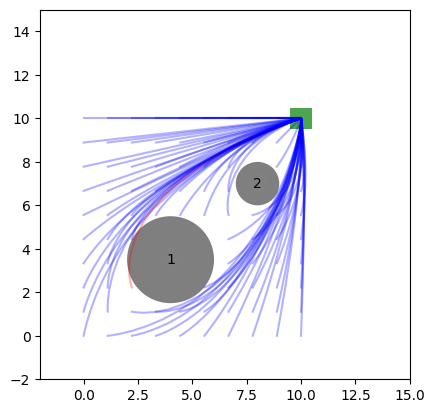

1


In [18]:
print(plot_tested_model(XS_Set, obs_set, target_high))
# print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

processing the animation ... 
... processing done


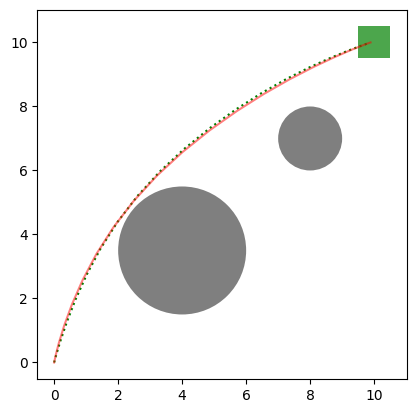

In [19]:
HTML(animateTraj(xs_optimal, xs, obs_set, target_high, sleep=500, animType=2).to_jshtml())

In [20]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.00000e+02  1.00000e+02  8.90302e+01  1.0000  0.00000e+00  9.93993e+00
   2  1.20616e+00  1.20616e+00  1.99231e+01  1.0000  1.13243e-14  1.82337e-01
   3  9.74278e-01  9.74278e-01  1.72399e+01  1.0000  2.39667e-08  9.91180e-02
   4  8.87035e-01  8.87035e-01  2.14404e+00  1.0000  1.79854e-08  1.38673e-02
   5  8.86305e-01  8.86305e-01  5.36054e-02  1.0000  2.66290e-09  1.30701e-04
 END  8.86305e-01  8.86305e-01  2.65187e-04   ----   5.59652e-11  2.72746e-07


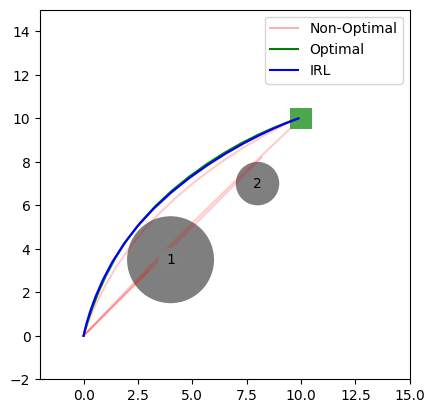

In [21]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [22]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs, us):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [23]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

NameError: name 'dt' is not defined

In [ ]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()

In [ ]:
# # Add a noisy trajectory to the set
# # scale = 1/traj_diff + 1.0
# scale = 5.0
# noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
# us.append(noisy_u)
# xs.append(np.stack(problem.rollout([noisy_u[i] for i in range(T)])))